In [16]:
# Deep Q Networks - Getting a Deep Q network to play Ms Pacman

# Used code from: https://github.com/pythonlessons/Reinforcement_Learning/blob/master/07_Pong-reinforcement-learning_DQN_CNN/Pong-v0_DQN_CNN_TF2.py

### SANITY TEST ##############################################################

# ENVIRONMENT SUMMARY: -> Pong-v0 
# -> Discrete action space
# -> The easiest atari game with discrete action space

# Observation -> 1 item
# An array of shape (210, 160, 3) corresponding to the screen image

# Action -> 6 items
# [‘NOOP’, ‘FIRE’, ‘RIGHT’, ‘LEFT’, ‘RIGHTFIRE’, ‘LEFTFIRE’]
# NOOP = FIRE, RIGHT = RIGHTFIRE, LEFT = LEFTFIRE
# so really only 3 actual actions

# Reward -> 1 item
# -1 for conceeding and +1 for scoring

### MAIN #######################################################################

# ENVIRONMENT SUMMARY: -> MsPacman-v0
# -> Discrete action space

# Observation -> 17 items
# 

# Action -> 6 items
#

# Reward -> 1 item
#

#################################################################################

import os
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
import cv2
import pickle
import imageio

def OurModel(input_shape, action_space):
    X_input = Input(input_shape)
    X = X_input
    
    X = Conv2D(32, 8, strides=(4, 4),padding="valid", input_shape=input_shape, activation="relu")(X)
    X = Conv2D(64, 4, strides=(2, 2),padding="valid", activation="relu")(X)
    X = Conv2D(64, 3, strides=(1, 1),padding="valid", activation="relu")(X)
    X = Flatten()(X)
    
    # 'Dense' is the basic form of a neural network layer
    X = Dense(512, activation="relu", kernel_initializer='he_uniform')(X)

    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)

    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)

    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X)
    model.compile(optimizer=Adam(lr=0.00005), loss='mean_squared_error')

    return model

class DQNAgent:
    def __init__(self, env_name):
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.env.seed(0)  
        self.action_size = self.env.action_space.n
        self.EPISODES = 1 #1000
        
        # Instantiate memory
        memory_size = 25000
        self.memory = deque(maxlen=memory_size)

        self.gamma = 0.99
        
        self.epsilon = 0.02 #1.0  
        self.epsilon_min = 0.02 
        self.epsilon_decay = 0.00002  
        
        self.batch_size = 32        

        self.ROWS = 80
        self.COLS = 80
        self.REM_STEP = 4        
        self.update_model_steps = 1000
        
        self.state_size = (self.ROWS, self.COLS,self.REM_STEP)
        self.image_memory = np.zeros(self.state_size)
        
        # create main model and target model
        self.model = OurModel(input_shape=self.state_size, action_space = self.action_size)
        self.target_model = OurModel(input_shape=self.state_size, action_space = self.action_size)
        
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        return
    
    def act(self, state, decay_step):    
        
        if self.epsilon > self.epsilon_min:
                self.epsilon *= (1-self.epsilon_decay)
        explore_probability = self.epsilon
            
        if explore_probability > np.random.rand():
            return random.randrange(self.action_size), explore_probability
        else:
            return np.argmax(self.model(state.reshape(1,80,80,4))), explore_probability
              
    def replay(self):        
        if len(self.memory) > self.batch_size:
            minibatch = random.sample(self.memory, self.batch_size)
        else:
            return

        state = np.zeros((self.batch_size, *self.state_size), dtype=np.float32)
        action = np.zeros(self.batch_size, dtype=np.int32)
        reward = np.zeros(self.batch_size, dtype=np.float32)
        next_state = np.zeros((self.batch_size, *self.state_size), dtype=np.float32)
        done = np.zeros(self.batch_size, dtype=np.uint8)

        for i in range(len(minibatch)):
            state[i], action[i], reward[i], next_state[i], done[i] = minibatch[i]
            
        target = np.array(self.model(state))        
        target_val = self.target_model(next_state)

        for i in range(len(minibatch)):
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.gamma * np.amax(target_val[i])         

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)

    def load(self, name):
        self.model.load_weights(name) 
        self.target_model.load_weights(name) 

    def save(self, name):
        self.model.save_weights(name)    

    def GetImage(self, frame):        
        #self.env.render()              
        frame_cropped = frame[35:195:2, ::2,:]        
        frame_rgb = 0.299*frame_cropped[:,:,0] + 0.587*frame_cropped[:,:,1] + 0.114*frame_cropped[:,:,2]
        new_frame = np.array(frame_rgb).astype(np.float32) / 255.0
        self.image_memory = np.roll(self.image_memory, 1, axis = 2)
        self.image_memory[:,:,0] = new_frame
        
        return self.image_memory.reshape(80,80,4)

    def reset(self):
        frame = self.env.reset()
        for i in range(self.REM_STEP):
            state = self.GetImage(frame)
        return state

    def step(self,action):
        next_state, reward, done, info = self.env.step(action)
        next_state = self.GetImage(next_state)
        return next_state, reward, done, info
    
    def run(self):
        decay_step = 0
        max_average = -21.0
        saved_scores = []
        frames = []
        
        for e in range(1, self.EPISODES + 1):
            
            print('Starting Episode: ', e)
            state = self.reset()
            done = False
            score = 0
        
            while not done:
                decay_step += 1
                action, explore_probability = self.act(state, decay_step)
                next_state, reward, done, _ = self.step(action)
                self.memory.append((state, action, reward, next_state, done))
                state = next_state
                score += reward                
                
                frames.append(self.env.render(mode = 'rgb_array'))   

                if done:                    
                    print('Episode: {} Score: {} Epsilon: {}'.format(e, score, self.epsilon))                     
                    saved_scores.append(score)                        
                    
                    imageio.mimsave('./Images/Pong.gif', frames, fps=30)
                    
                    if e % 10 == 0:

                        # save results
                        with open("./Results/rewards-ep-" + str(e) + ".txt", "wb") as file:
                            pickle.dump(saved_scores, file) 

                        # save model
                        self.save('./Models/DQN_Model.h5')

                        # save the replay
                        with open("./Replays/replay1.txt", "wb") as file:
                            pickle.dump(self.image_memory, file)
                    
                            
                # update the models            
                if decay_step % 1000 == 0:
                    self.update_target_model()
                    pass
                    
                if decay_step % 1 == 0:
                    self.replay()
                    pass

        # close environemnt when finish training
        self.env.close()
        

if __name__ == "__main__":
    env_name = 'Pong-v0'
    agent = DQNAgent(env_name)
    agent.load('./Models/Pong/DQN_Model-310ep.h5')
    agent.run()

Starting Episode:  1
Episode: 1 Score: -15.0 Epsilon: 0.02


/home/hemerson/anaconda3/envs/cs285/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hemerson/anaconda3/envs/cs285/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


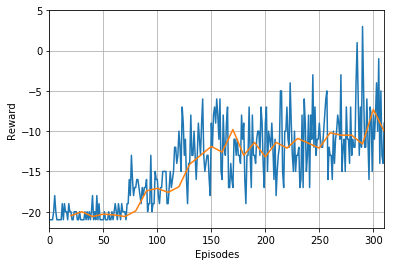

In [12]:
import matplotlib.pyplot as plt
import pickle
import numpy as np


with open("./Results/Pong/rewards-ep-180-1.txt", "rb") as file:
    a = pickle.load(file)  
    
with open("./Results/Pong/rewards-ep-230-1.txt", "rb") as file:
    b = pickle.load(file)  
    
with open("./Results/Pong/rewards-ep-310-1.txt", "rb") as file:
    c = pickle.load(file)  

tot = a + b + c    

mean = []
for i in range(len(tot)):
    
    if i % 10 == 0:
        mean.append(np.mean(tot[i - 10 : i]))   
               
    
x1 = np.array(range(1,311))
y1 = tot
x2 = np.array(range(1, 32)) * 10
y2 = mean

plt.plot(x1,y1)
plt.plot(x2,y2)
plt.xlim(0, 310)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.ylim(-22, 5)
plt.grid(alpha=1.0)
# plt.savefig('./Images/Pon.png')

#plt.show()
    
    
